# Chapter 11: Text-to-Image Generation with Latent Diffusion

This chapter covers

* The idea behind Latent Diffusion Models (LDMs)
* How a variational autoencoder (VAE) converts low-resolution images into high resolution ones 
* Conducting forward and reverse diffusion processes in the latent space
* Using a pretrained LDM to generate high resolution images based on text prompts

In the previous chapter, you learned how to generate images from text using CLIP-guided diffusion. The generated images started to look coherent and contextually relevant. The basic idea behind CLIP-guided diffusion is sound, but the process is computationally costly. The primary reason for the poor performance is that high-resolution images contain many pixels, making the training of a diffusion model computationally expensive. Specifically, we need to add noise to images over many time steps (e.g., 1000 time steps) in the forward diffusion process. We then need to denoise the images iteratively when training the diffusion model. Further, each high-resolution image contains many pixels: for example, an image of size (3, 512, 512) has 3x512x512=786,432 pixels. As a result, both the training and inference processes of CLIP-guided diffusion are very computationally intensive and slow.

In 2022, Rombach et al. published a paper titled "High-Resolution Image Synthesis with Latent Diffusion Models" (https://arxiv.org/abs/2112.10752). Instead of conducting the forward and reverse diffusion processes on high-resolution images, the authors propose conducting the diffusion processes in the latent space. Since images in the latent space are much smaller in size, the diffusion processes are much faster. Once the latent diffusion model is trained, a variational autoencoder (VAE) is used to convert the low-resolution images in the latent space into high-resolution images as the final output. Furthermore, the authors introduced cross-attention layers into the model architecture, transforming diffusion models into powerful and flexible generators for general conditioning inputs such as text or bounding boxes, and enabling high-resolution synthesis. They named their model Latent Diffusion Models (LDMs). LDMs achieved new state-of-the-art results for image editing and restoration and showed highly competitive performance on various tasks.

In this chapter, you'll learn how LDMs work. Instead of conducting forward and reverse diffusion processes on high-resolution images of size (3, 512, 512), the LDM in this chapter conducts diffusion processes in a latent space where the latents have dimensions of (4, 64, 64). This reduces the size of the input to the diffusion models by 48 times since (3x512x512)/(4x64x64)=48. This greatly speeds up the diffusion processes. Once the diffusion model is trained, a text prompt is fed to the model to generate latents with a size of (4, 64, 64). These latents are then fed to a trained VAE, which converts them into high-resolution images of size (3, 512, 512). 

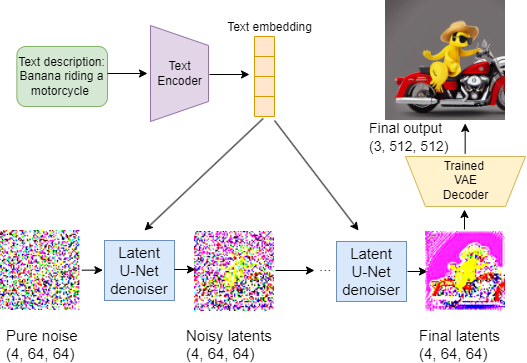
Figure 11.1 How latent diffusion models work

Figure 11.1 is a diagram of the steps involved in text to image generation with the latent diffusion model (LDM). To generate an image, we first encode the text prompt ("A banana riding a motorcycle with sunglasses and a straw hat," for example) into a text embedding (top left of Figure 11.1). We then start the reverse diffusion process in the latent space, as illustrated in the bottom half of Figure 11.1. We iteratively denoise a noisy image, conditional on the text embedding so the generated image matches the text embedding. This step is guided by a trained CLIP model: the CLIP guides the image generation by maximizing the similarity between the text embedding and the embedding of the generated image. Once the reverse diffusion process is finished in the latent space, the latent image is presented to a trained VAE to convert it to a high-resolution image, which is the final output of the model (top right of Figure 11.1). 

Figure 11.2 shows four images generated with four different prompts by using the pretrained LDM.

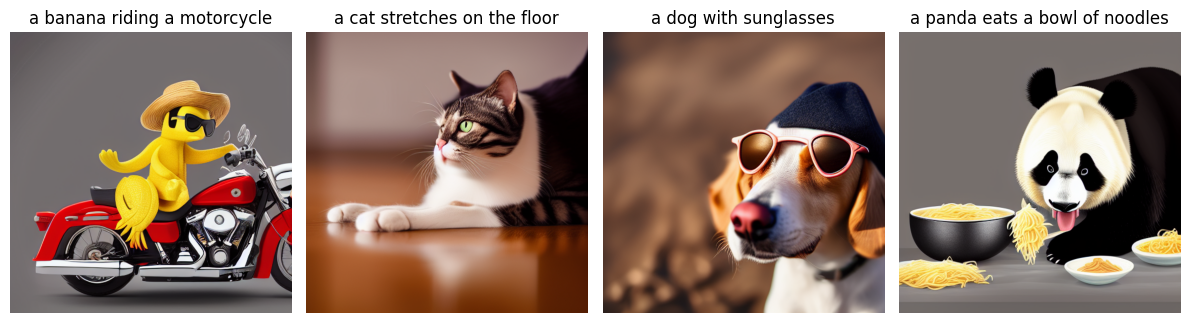
Figure 11.2 Images generated with a pretrained LDM. The prompt is on top of the corresponding image. 

LDMs are also excellent image editors. In Figure 11.3, the original horse image is in the middle. When we use the prompt "white horse on sunny beach" to edit the image, the result is shown on the left of Figure 11.3. When we use the prompt "zebra on snowy ground" to edit the image, the result is shown on the right of Figure 11.3. 

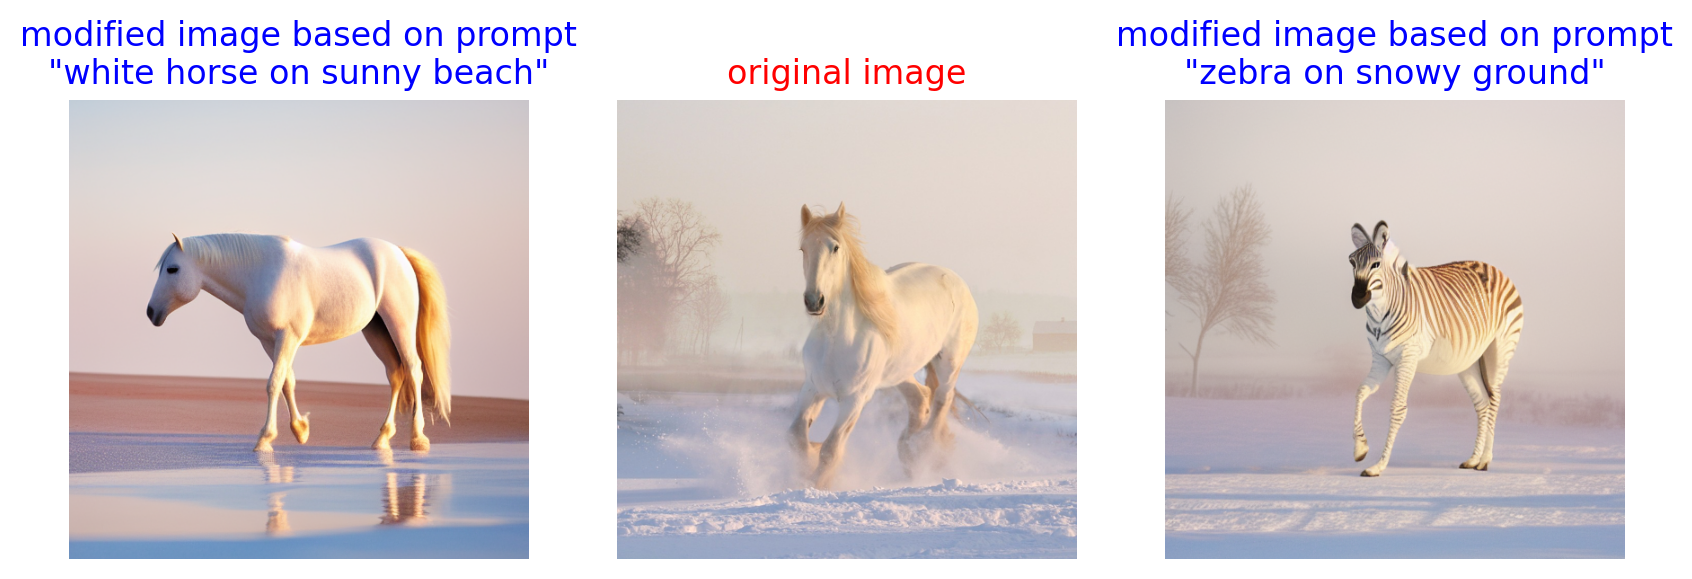
Figure 11.3 Use a pretrained latent diffusion model to edit an image. The original image is in the middle. After we use the prompt "white horse on sunny beach" to edit the image, the result is shown on the left. After we use the prompt "zebra on snowy ground" to edit the image, the result is shown on the right. 

# 1.    How VAEs Encode and Decode Images?
A Variational Autoencoder (VAE) is a type of generative model that combines principles from deep learning and Bayesian inference to generate new data points similar to a given dataset. It consists of two main components: an encoder and a decoder, both are deep neural networks. The encoder maps the input data to a latent space, producing parameters (mean and variance) for a probability distribution (usually Gaussian) in this space. The decoder maps the latent variables sampled from the probability distribution back to the data space, reconstructing the input data.

Instead of encoding data directly to a point in latent space, VAEs encode data to a distribution over the latent space, promoting smooth interpolation between data points. The loss function of a VAE includes a regularization term (Kullback-Leibler divergence) that ensures the learned latent space distribution is close to a prior distribution (usually a standard normal distribution).

In the paper "High-Resolution Image Synthesis with Latent Diffusion Models" by Rombach et al. (2022), VAEs play a crucial role in the architecture of Latent Diffusion Models (LDMs). The VAE encodes high-dimensional image data into a lower-dimensional latent space. This encoding helps reduce computational complexity and makes it feasible to apply diffusion models to high-resolution images. The VAE compresses images into latent codes, which can then be used for training the diffusion model. After the diffusion process, the VAE decoder reconstructs the high-resolution images from these latent codes. The VAE's regularization properties ensure that the latent space is well-structured, promoting stability and efficiency in the training of the diffusion models.

By working in the latent space, the diffusion model operates on a lower-dimensional representation, which is more computationally efficient and manageable. The VAE ensures that the latent space captures the essential features of the images, enabling effective diffusion modeling.
The combination of VAEs with latent diffusion models allows the framework to handle high-resolution images effectively, leveraging the strengths of both VAEs (for dimensionality reduction and regularization) and diffusion models (for generating realistic images).

In this section, you'll first download the pretrained VAE. You'll then encode high resolution images to the latent space. After that, you'll use the decoder in VAE to reconstruct the image. You'll compare the reconstructed images with the original ones and see if any information is lost in the process. 

The Python programs in this chapter are based on two excellent GitHub repositories: one by the Computer Vision and Learning research group at Ludwig Maximilian University of Munich (https://github.com/CompVis/latent-diffusion) and one by Umar Jamil (https://github.com/hkproj/pytorch-stable-diffusion). 

## 1.1 Download and Pre-Trained VAE
First, download the two files vocab.json and merges.txt from https://huggingface.co/runwayml/stable-diffusion-v1-5/tree/main/tokenizer and save them in the /files/ folder on your computer. Then go to https://huggingface.co/ogkalu/Illustration-Diffusion/tree/main and download the file hollie-mengert.ckpt and save it in the /files/ folder on your computer. 

Run the following code cell to clone Umar Jamil's GitHub repository:

In [1]:
!git clone https://github.com/hkproj/pytorch-stable-diffusion

Cloning into 'pytorch-stable-diffusion'...


We'll load the trained VAE as follows:

In [2]:
# access the directory /pytorch-stable-diffusion/sd/
import sys
sys.path.append("pytorch-stable-diffusion/sd")

from model_converter import load_from_standard_weights
from encoder import VAE_Encoder
from decoder import VAE_Decoder
import torch

# load pre-trained weights
device="cuda" if torch.cuda.is_available() else "cpu"
model_file = r"D:\MANNING\diffusion\StableDiffusion\pytorch-stable-diffusion-main\sd\data/hollie-mengert.ckpt"
#model_file = "files/hollie-mengert.ckpt"
state_dict = load_from_standard_weights(model_file, device)
# create VAE encoder
encoder = VAE_Encoder().to(device)
encoder.load_state_dict(state_dict['encoder'], strict=True)
# create VAE decoder
decoder = VAE_Decoder().to(device)
decoder.load_state_dict(state_dict['decoder'], strict=True)

<All keys matched successfully>

Download the two image files beaver.jpg and dolphin.png from the book's GitHub repository https://github.com/markhliu/txt2img and place them in the /files/ folder on your computer. We'll load the two images and use the pre-trained VAE encoder to compress them to the latent space: 

In [3]:
from PIL import Image
from torchvision import transforms

def center_crop(img):   
    width, height = img.size   
    new=min(width,height)
    left = (width - new)/2
    top = (height - new)/2
    right = (width + new)/2
    bottom = (height + new)/2
    im = img.crop((left, top, right, bottom))
    return im
f1=center_crop(Image.open("files/beaver.jpg")).resize((512,512))
f2=center_crop(Image.open("files/dolphin.png")).resize((512,512))
transform=transforms.ToTensor()
f1=transform(f1)
f2=transform(f2)
print(f1.shape,f2.shape)

torch.Size([3, 512, 512]) torch.Size([3, 512, 512])


## 1.2 Encode and Decode Images Using the Pre-Trained VAE
Both images have a size of (3, 512, 512), meaning three color channels, with width and height of 512 pixels. We now compress them to the latent space:

In [4]:
N=torch.distributions.Normal(0, 1)
noise=N.sample(torch.Size([1,4,64,64])).to(device)
latents1=encoder(f1.unsqueeze(0).to(device),noise)[0]
latents2=encoder(f2.unsqueeze(0).to(device),noise)[0]
encoder.to("cpu")
print(latents1.shape,latents2.shape)

torch.Size([4, 64, 64]) torch.Size([4, 64, 64])


The latents have sizes (4, 64, 64).

Now, let's compare the original images with the images in the latent space:

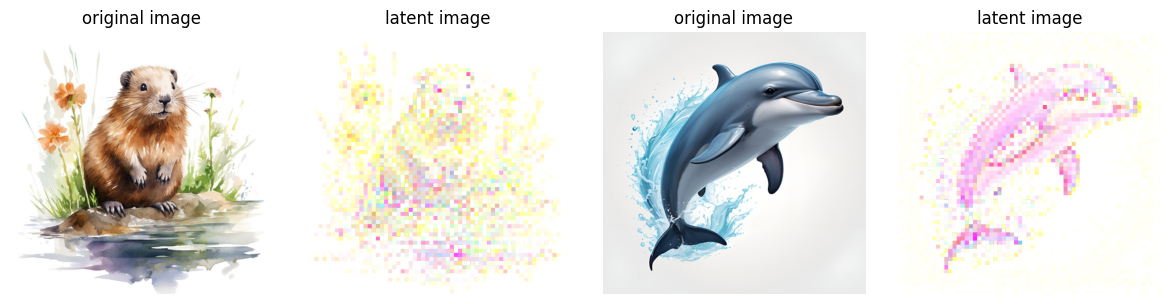

In [5]:
import matplotlib.pyplot as plt
import numpy as np 

imgs=[f1.permute(1,2,0),
  torch.clip(latents1.permute(1,2,0),-1,1).detach().cpu().numpy(
      ).repeat(8, axis=0).repeat(8,axis=1)/2+0.5,
      f2.permute(1,2,0),\
  torch.clip(latents2.permute(1,2,0),-1,1).detach().cpu().numpy(
  ).repeat(8, axis=0).repeat(8,axis=1)/2+0.5]    
plt.figure(figsize=(12,3),dpi=100)
for i in range(4):
    plt.subplot(1,4, i+1)
    plt.imshow(imgs[i])
    if i%2==0:
        plt.title("original image")
    else:
        plt.title("latent image")        
    plt.axis('off')
plt.tight_layout()
plt.show()

The images in the latent space use only about 2% of the pixels of the original images. However, the plotted latents do have the shape of the original images. 

Next, we use the pretrained VAE decoder to reconstruct the images based on the images in the latent space. 

In [6]:
reconstruct1=decoder(latents1.unsqueeze(0))
reconstruct2=decoder(latents2.unsqueeze(0))

We can now compare the originals with the reconstructed images:

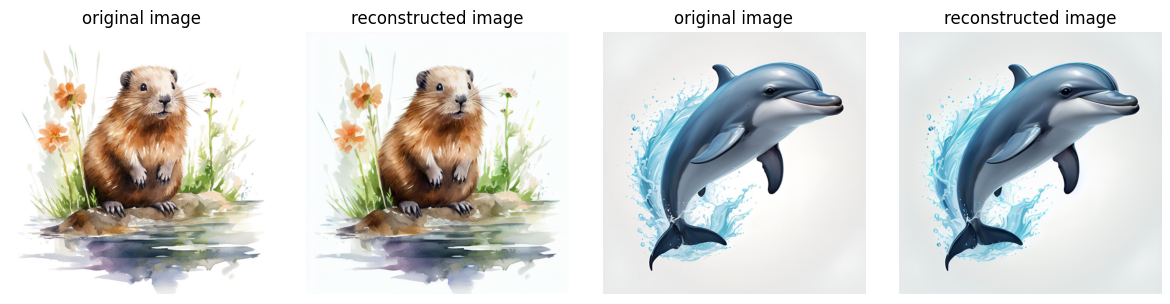

In [7]:
imgs=[f1.permute(1,2,0),
  torch.clip(reconstruct1[0].permute(1,2,0),
    0,1).detach().cpu().numpy(),
    f2.permute(1,2,0),
  torch.clip(reconstruct2[0].permute(1,2,0),
             0,1).detach().cpu().numpy()]    
plt.figure(figsize=(12,3),dpi=100)
for i in range(4):
    plt.subplot(1,4, i+1)
    plt.imshow(imgs[i])
    if i%2==0:
        plt.title("original image")
    else:
        plt.title("reconstructed image")        
    plt.axis('off')
plt.tight_layout()
plt.show()

The reconstructed images look even more detailed than the original images. 

# 2. Guidance by the CLIP Model
The diffusion process is conducted in the latent space, guided by the CLIP model. In this section, we discuss how the CLIP model provide guidance to the diffusion model to generate latent images that match the descriptions in the text prompt. 

We'll use the pretrained CLIP tokenizer from the transformers library to tokenize the text prompt. Make sure you have the two files tokenizer_vocab.json and tokenizer_merges.txt that you downloaded earlier in the /files/ folder on your computer. 

In [8]:
from transformers import CLIPTokenizer
from clip import CLIP

tokenizer = CLIPTokenizer(r"D:\MANNING\diffusion\StableDiffusion\pytorch-stable-diffusion-main\sd\data/tokenizer_vocab.json", 
    merges_file=r"D:\MANNING\diffusion\StableDiffusion\pytorch-stable-diffusion-main\sd\data/tokenizer_merges.txt")
clip = CLIP().to(device)
clip.load_state_dict(state_dict['clip'], strict=True)

<All keys matched successfully>

We'll use "A banana riding a motorcycle, wearing sunglasses and a straw hat" as our prompt. There is an optional negative prompt or unconditional prompt, which tells the model not to do in the image. For now, we'll leave the negative prompt empty.

In [9]:
prompt = '''A banana riding a motorcycle, wearing sunglasses and
a straw hat, highly detailed, ultra sharp, cinematic, 
100mm lens, 8k resolution.'''

uncond_prompt=""

seed=42
with torch.no_grad():
    generator=torch.Generator(device=device)
    generator.manual_seed(seed)
    # convert to a list of seq_len=77
    cond_tokens=tokenizer.batch_encode_plus(
    [prompt], padding="max_length", max_length=77).input_ids    
    cond_tokens=torch.tensor(cond_tokens,
                             dtype=torch.long,device=device)
    cond_context = clip(cond_tokens).to(device)
    uncond_tokens=tokenizer.batch_encode_plus(
        [uncond_prompt], padding="max_length", 
        max_length=77).input_ids    
    uncond_tokens=torch.tensor(uncond_tokens,
                       dtype=torch.long,device=device)
    uncond_context = clip(uncond_tokens).to(device)    
    clip.to("cpu")
    context=torch.cat([cond_context,uncond_context])

The CLIP tokenizer converts both the prompt and the negative prompt into text embeddings and then concatenates them into one single tensor called $context$. 

# 3.	Diffusion Process in the Latent Space
We'll conduct CLIP guided diffusion in the latent space. 

## 3.1. The Diffuser and the Noise Scheduler
We load the pretrained diffuser model as follows:

In [10]:
from diffusion import Diffusion

diffusion = Diffusion().to(device)
diffusion.load_state_dict(state_dict['diffusion'], strict=True)

<All keys matched successfully>

We use the DDPM noise scheduler:

In [11]:
import torch
from ddpm import DDPMSampler

def get_time_embedding(timestep):
    # Shape: (160,)
    freqs = torch.pow(10000, -torch.arange(start=0,
                   end=160, dtype=torch.float32) / 160) 
    # Shape: (1, 160)
    x = torch.tensor([timestep], 
         dtype=torch.float32)[:, None] * freqs[None]
    # Shape: (1, 160 * 2)
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

num_reference_steps=50
# sampler
sampler=DDPMSampler(generator)
sampler.set_inference_timesteps(num_reference_steps)

## 3.2 Image Generation in the Latent Space
We'll generate image in the latent space using CLIP guided diffusion.

In [12]:
from tqdm import tqdm
from copy import deepcopy

cfg_scale=8
# latent space dimension
latent_shape=(1,4,64,64)
# save intermediate images during diffusion process 
noisy_latents=[]

with torch.no_grad():
    # start with pure noise
    latents=torch.randn(latent_shape,
                        generator=generator,device=device)
    # denosing the latents
    timesteps=tqdm(sampler.timesteps)
    for i, timestep in enumerate(timesteps):
        time_embedding=get_time_embedding(timestep).to(device)
        model_input=latents.to(device)
        model_input=model_input.repeat(2,1,1,1)
        # predict noise
        model_output=diffusion(model_input,context,time_embedding)
        output_cond,output_uncond=model_output.chunk(2)
        model_output=cfg_scale*(output_cond-output_uncond)+\
            output_uncond
        # denoising: remove noise from image 
        latents=sampler.step(timestep,latents,model_output)
        if i%10==9:
            noisy_latents.append(deepcopy(latents))
    # decode latent image to high-resolution image
    images=decoder(latents)
diffusion.to("cpu")    

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [17:41<00:00, 21.24s/it]


We can display the final generated image as follows:

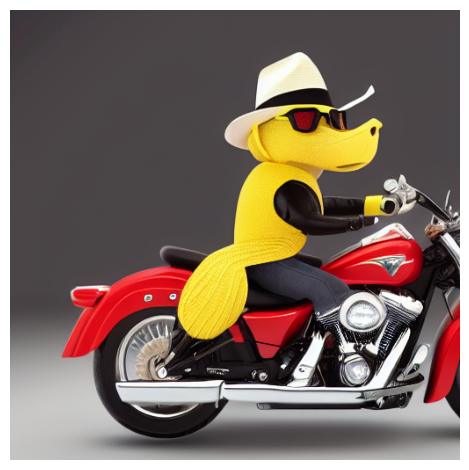

In [13]:
import matplotlib.pyplot as plt

img=torch.clip(images[0].permute(1,2,0)/2+0.5,0,1)
plt.figure(dpi=100)
plt.imshow(img.cpu().numpy())
plt.axis("off")
plt.tight_layout()
plt.show()  

## 3.3 View the Latent Images and Intermediate Steps
We have seen the final generated image above, which is very realistic. You may wonder how the generated image looks like in the latent space. Further, to refine the latent image, the diffusion model started with pure noise and gradually removed noise to generate the final latent image. We have saved the intermediate latent images in the list noisy_latents. 

Let's plot the latent images after 20%, 40%, ..., 100% of the inference time steps. 

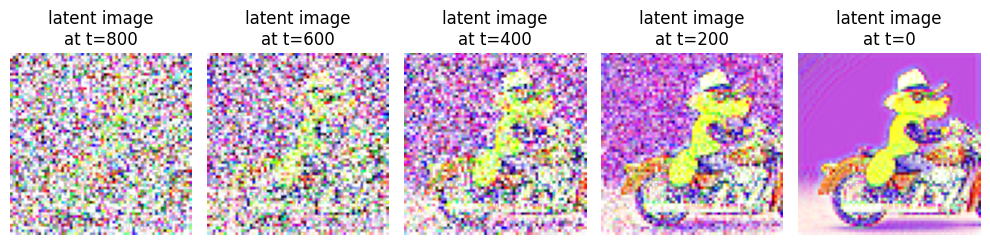

In [14]:
plt.figure(figsize=(10,3),dpi=100)
for i in range(5):
    im=torch.clip(noisy_latents[i][0].permute(1,2,0)/2+0.5,0,1)
    plt.subplot(1,5, i+1)
    plt.imshow(im.cpu().numpy())
    plt.title(f"latent image\nat t={800-i*200}")        
    plt.axis('off')
plt.tight_layout()
plt.show() 

Now, if we were to decode the intermediate latent images to high resolution images, they look like this:

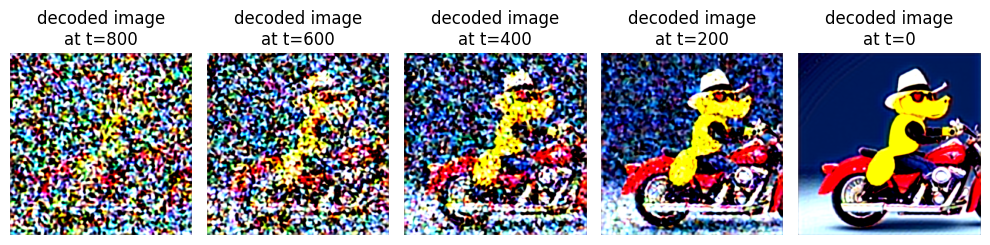

In [15]:
plt.figure(figsize=(10,3),dpi=100)
for i in range(5):
    im=decoder(noisy_latents[i])
    im=torch.clip(im[0].permute(1,2,0)/2+0.5,0,1)
    plt.subplot(1,5, i+1)
    plt.imshow(im.detach().cpu().numpy())
    plt.title(f"decoded image\nat t={800-i*200}")        
    plt.axis('off')
plt.tight_layout()
plt.show() 

The reconstructed image would have looked like the above subplots during the diffusion process. 

# 4.	Modify Existing Images
The latent diffusion model can also modify existing images based on a text prompt. The process is similar to what we have done above, except that the starting point for the diffusion process is not pure noise. It's an existing image, compressed into the latent space. 

In [16]:
import pipeline
import model_loader

models=model_loader.preload_models_from_standard_weights(model_file,"cuda")
prompt="A white horse walks on the sandy beach under blue sky."
uncond_prompt="black and white image"
input_image = Image.open("files/horse.png")

output_image = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=0.8,
    do_cfg=True,
    cfg_scale=8,
    sampler_name="ddpm",
    n_inference_steps=50,
    seed=42,
    models=models,
    device="cuda",
    idle_device="cpu",
    tokenizer=tokenizer,)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [12:10<00:00, 18.27s/it]


We start with a white horse running in the snow. We use the prompt "A white horse walks on the sandy beach under blue sky." The end result is a new image. We still have a white horse resembling the white horse in the original image. However, the background is now a sunny sandy beach instead of a cold white snow-covered field, as you can see from the image below after plotting it with the matplotlib library:

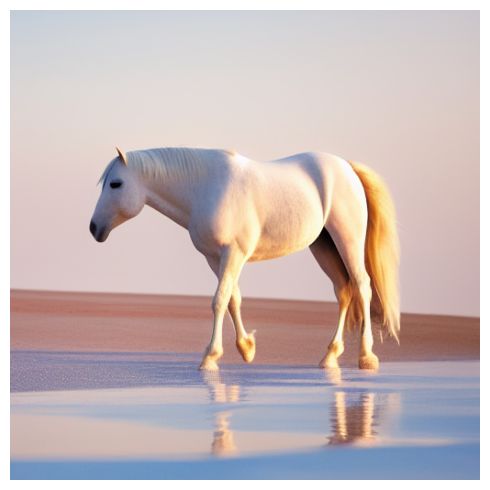

In [17]:
plt.figure(figsize=(5,5),dpi=100)
plt.imshow(output_image)    
plt.axis('off')
plt.tight_layout()
plt.show() 

Let's try another example of modifying existing images. We'll start with the same image of white horse with snow background. However, we change the prompt to "A zebra walks on the white, snow-covered ground."

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [07:25<00:00, 17.81s/it]


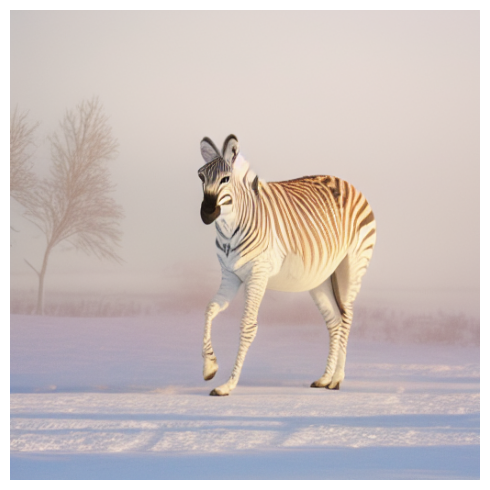

In [18]:
prompt="A zebra walks on the white, snow-covered ground."

output_image2 = pipeline.generate(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=input_image,
    strength=0.5,
    do_cfg=True,
    cfg_scale=8,
    sampler_name="ddpm",
    n_inference_steps=50,
    seed=42,
    models=models,
    device="cuda",
    idle_device="cpu",
    tokenizer=tokenizer,)
plt.figure(figsize=(5,5),dpi=100)
plt.imshow(output_image2)    
plt.axis('off')
plt.tight_layout()
plt.show() 